# Hospital - Error Detection using GRUs


In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed
import time 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed(42)

## Read the data

In [7]:
#df = pd.read_csv('train_test_hosp_dataset.csv', encoding='utf8',dtype=object)

In [8]:
df = pd.read_csv('hospital_final_train.csv', encoding='utf8',dtype=object)
df = df.sample(frac=1)

In [9]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,Condition,MeasureCode,MeasureName,Score,Sample,Stateavg,label
438,20017,alaska regional hospital,2801 debarr road,anchorage,ak,99508,anchorage,9072761131,acute care hospitals,proprietary,yes,pneumonia,pn-4,pneumonia patients given smoking cessation adv...,96%,26 patients,ak_pn-4,1
954,10047,georgiana hospital,515 miranda st,georgiana,al,36033,butler,3343762205,acute care hospitals,voluntary non-profit - private,no,surgical infection prevention,scip-vte-2,patients who got treatment at the right time ...,empty,empty,al_scip-vte-2,1
997,10050,st vincents blount,150 gilbreath drive,oneonta,al,35121,blount,2052743000,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-card-2,surgery patients who were taking heart drugs c...,25%,8 patients,al_scip-card-2,1


In [10]:
df['label'].value_counts()

1    699
0    301
Name: label, dtype: int64

### Separate the labels from the training data

In [13]:
start = time.time()

In [14]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [15]:
dftestList = df.values.tolist()

In [16]:
df.drop(columns=['label'], axis=1, inplace=True)

In [17]:
df.shape

(1000, 17)

### Convert each row to a space separated string

In [18]:
dfList = df.values.tolist()

In [19]:
dfCol = df.columns.tolist()
dfCol.append('label')

In [20]:
rows = []
for rownum in range(len(dfList)):
    combined = ':'.join([str(x) for x in dfList[rownum]])
    rows.append(combined)

In [21]:
testSet= []
labels_test = []
for i in range(int(0.7*len(dfList)), len(dfList)):
    combined = ':'.join([str(x) for x in dfList[i]])
    testSet.append(combined)
    labels_test.append(labels[i])
index = np.arange(len(testSet))

In [22]:
rows[0]

'20017:alaska regional hospital:2801 debarr road:anchorage:ak:99508:anchorage:9072761131:acute care hospitals:proprietary:yes:pneumonia:pn-4:pneumonia patients given smoking cessation advice/counseling:96%:26 patients:ak_pn-4'

In [23]:
max([len(r) for r in rows])

432

In [24]:
count = sum(df.nunique())

In [25]:
df.nunique()

ProviderNumber       63
HospitalName         56
Address1             61
City                 52
State                 4
ZipCode              54
CountyName           47
PhoneNumber          58
HospitalType          8
HospitalOwner        15
EmergencyService      7
Condition            16
MeasureCode          39
MeasureName          38
Score                62
Sample              320
Stateavg             57
dtype: int64

### Save the dataset

In [26]:
df.to_csv("HospitalTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

In [27]:
maxSequenceLength = max([len(r) for r in rows])
maxWords = int(2 * count)

In [28]:
tokenizer = Tokenizer(num_words=maxWords, split=':')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [29]:
len(word_index)

905

In [30]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [31]:
data.shape

(1000, 432)

In [32]:
len(labels)

1000

## Train test split

### Store the test data

In [33]:
indices = np.arange(data.shape[0])

In [34]:
data = data[indices]
labels = labels[indices]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [36]:
len(X_train), len(y_train)

(800, 800)

In [37]:
len(X_test), len(y_test)

(200, 200)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional GRU layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [38]:
embeddingDim = 100

In [39]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 432, 100)          191400    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              63744     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 255,785
Trainable params: 255,529
Non-trainable params: 256
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=32, 
                    validation_split=0.1)

Epoch 1/8
23/23 [==============================] - 15s 440ms/step - loss: 0.7173 - binary_accuracy: 0.6458 - val_loss: 0.6119 - val_binary_accuracy: 0.7250
Epoch 2/8
23/23 [==============================] - 10s 420ms/step - loss: 0.5377 - binary_accuracy: 0.7389 - val_loss: 0.5295 - val_binary_accuracy: 0.8375
Epoch 3/8
23/23 [==============================] - 8s 353ms/step - loss: 0.3976 - binary_accuracy: 0.8250 - val_loss: 0.5274 - val_binary_accuracy: 0.7750
Epoch 4/8
23/23 [==============================] - 8s 364ms/step - loss: 0.1543 - binary_accuracy: 0.9417 - val_loss: 0.2883 - val_binary_accuracy: 0.8625
Epoch 5/8
23/23 [==============================] - 8s 350ms/step - loss: 0.0488 - binary_accuracy: 0.9847 - val_loss: 0.4339 - val_binary_accuracy: 0.8625
Epoch 6/8
23/23 [==============================] - 8s 349ms/step - loss: 0.0194 - binary_accuracy: 0.9958 - val_loss: 0.5967 - val_binary_accuracy: 0.8750
Epoch 7/8
23/23 [==============================] - 9s 376ms/step - l

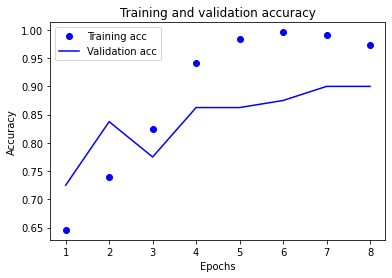

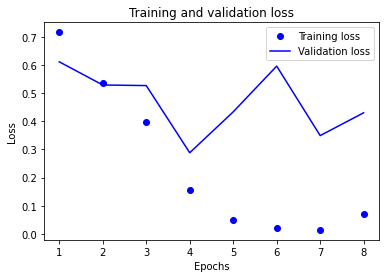

In [42]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [43]:
print("Training time" + str(time.time() - start))

Training time100.32320094108582


## Evaluation on test set

In [44]:
results = model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 71ms/step - loss: 0.9394 - binary_accuracy: 0.8100


## Save the model and tokenizer for future use

In [45]:
model.save("HospitalErrorDetectionMultiAttributeClassifier.h5")

In [46]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Run model on the test dataset

In [47]:
start = time.time()

In [48]:
model = load_model('HospitalErrorDetectionMultiAttributeClassifier.h5')

In [49]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [50]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=maxSequenceLength)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [51]:
ourLabels = []

#for row in rows:
#    label = classifyTuples(model, tokenizer, row)
#    ourLabels.append(row + ':' + str(label))
for row in testSet:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append(row + ':' + str(label))

In [52]:
len(ourLabels)

300

In [53]:
with open('HospitalDatasetPredictions.pkl', 'wb') as f:
    pickle.dump(ourLabels, f)

In [54]:
ourLabels = np.asarray(ourLabels)
ourLabels = ourLabels[index]

## Get only the faulty tuples

In [55]:
with open('HospitalDatasetPredictions.pkl', 'rb') as f:
    ourLabels = pickle.load(f)

In [56]:
errors_test = [row for row in ourLabels if row[-1] == '0']

In [66]:
errors_test

['10036:andalusia regional hospital:849 south three notch street:andalusia:al:36420:covington:334222x466:acute care hospitals:proprietary:no:surgical infection prevention:scip-inf-2:surgery patients who were given the  right kind  of antibiotic to help prevent infection:88%:141 patients:al_scip-inf-2:0',
 '10022:cherokee medical center:400 northwood dr:centre:al:35960:cherokee:2569275531:xcute care hospitals:voluntary non-profit - private:yes:heart failure:hf-2:heart failure patients given an evaluation of left ventricular systolic (lvs) function:94%:48 patients:al_hf-2:0',
 'nan:riverview regional medical center:600 south third street:gadsden:al:35901:etowah:2565435200:acute care hospitals:proprietary:yes:children s asthma care:cac-1:children who received reliever medication while hospitalized for asthma:100%:4 patients:al_cac-1:0',
 '10047:georgiana hospital:515 miranda st:georgiana:al:36033:butler:3343762205:acutx care hospitals:voluntary non-profit - private:no:pneumonia:pn-6:pneum

In [58]:
with open('HospitalDatasetErrors.pkl', 'wb') as f:
    pickle.dump(errors_test, f)

### Convert pickle to dataframe

In [67]:
values = [row.split(':') for row in errors_test]

In [68]:
len(values)

91

In [74]:
len(values)

91

In [61]:
headers = df.columns.tolist()
headers.append('label')

In [62]:
df = pd.DataFrame(values, columns=headers)

In [63]:
df.to_csv('HospitalErrors.csv',encoding='utf8',index=False)

## Metrics

In [64]:
from sklearn.metrics import classification_report

y_pred = []
for i in ourLabels:
    y_pred.append(int(i.split(':')[-1]))
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       104
           1       0.93      0.99      0.96       196

    accuracy                           0.95       300
   macro avg       0.96      0.93      0.94       300
weighted avg       0.95      0.95      0.95       300



In [65]:
print("Runtime:" + str(time.time()-start))

Runtime:156.09369111061096
